## Load product data

In [715]:
import pandas as pd
import math
import numpy as np

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import copy as cp

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch
from sklearn.manifold import TSNE

from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import statsmodels.api as sm
from scipy import stats

from IPython.display import display

%load_ext autoreload
%autoreload 1
%aimport Helpers

import Helpers as hlp

pd.options.display.float_format = '{:,.2f}'.format

interim_path = "..\\data\\interim\\"

file_name = "HistPerProduct_p2c1.csv"
df_HistPerProduct_p2c1 = pd.read_csv(interim_path + file_name , sep = ";", encoding = 'utf-8', header = 0)


product_raw_df = df_HistPerProduct_p2c1
cols = product_df.columns.values
cols[0]  = 'product'
product_raw_df.columns =cols
product_raw_df.head()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


product   201601   201602   201603   201604   201605   201606  \
0  GLA001VLR125FS 2,173.00 2,571.00 2,697.00 2,714.00 2,795.00 2,915.00   
1  GWC012NEU500FS   125.00   111.00    97.00    76.00    81.00    80.00   
2  GLV001NTA100FS 3,254.00 2,450.00 2,264.00 3,334.00 3,149.00 3,174.00   
3  GLV001BND060SS 1,452.00 1,592.00 1,444.00 1,435.00 1,424.00 1,409.00   
4  GWP007PAM080FP 1,228.00 1,272.00 1,219.00 1,256.00 1,261.00 1,246.00   

    201607   201608   201609   ...      201743   201744   201745   201746  \
0 2,931.00 3,069.00 2,965.00   ...        0.00     0.00     0.00     0.00   
1    46.00    48.00    54.00   ...      440.00   199.00     0.00     0.00   
2 3,200.00 3,375.00 3,782.00   ...    4,179.00 4,035.00 3,031.00 3,506.00   
3 1,549.00 1,507.00 1,405.00   ...    1,324.00 1,554.00 1,690.00 1,340.00   
4 1,329.00 1,310.00 1,301.00   ...    1,231.00 1,163.00 1,220.00 1,186.00   

    201747   201748   201749   201750   201751   201752  
0     0.00     0.00     0.00     0.00     0.00     0.00  
1     0.00     0.00     0.00     0.00     0.00     0.00  
2 3,696.00 3,800.00 2,962.00 3,048.00 2,896.00 3,204.00  
3 1,384.00 1,256.00 1,201.00 1,132.00 1,328.00 1,333.00  
4 1,191.00 1,149.00 1,064.00 1,204.00 1,173.00   835.00  

[5 rows x 105 columns]

# Cleaning Series

## Trailing zeros

In [713]:
product_df = product_raw_df.fillna(0)
t = 10

#mask on the t last columns being >0
mask = product_df.iloc[:,-t:].all(axis=1)>0
product_df = product_df[mask]
print("Series With %d trailing zeros removed"%t)
print(product_df.shape)

Series With 10 trailing zeros removed
(299, 105)


## Rare sales

In [714]:
total = product_df.shape[1]
t = 5

rare =product_df.where((product_df>0)).count(axis=1)>total-t
product_df = product_df[rare]
print("Series With less than %d values removed"%t)
print(product_df.shape)


Series With less than 5 values removed
(230, 105)


# Pre-process Data
Apply a Z-normalization (subtract the mean and divide by the standard deviation)

In [711]:
data = product_df.as_matrix()[:,1:].astype(float)


X_df = pd.DataFrame(data,columns = product_df.columns[1:])
X_df.head()

X_m =data - data.mean(axis = 1, keepdims=True)
X_z = X_m / data.std(axis = 1, keepdims=True) 

X_df_z = pd.DataFrame(X_z,columns = product_df.columns[1:])
X_df_z.head()


201601  201602  201603  201604  201605  201606  201607  201608  201609  \
0   -0.20   -0.90   -1.06   -0.13   -0.29   -0.27   -0.25   -0.09    0.26   
1   -0.59   -0.36   -0.60   -0.61   -0.63   -0.66   -0.43   -0.50   -0.66   
2    0.22    0.46    0.17    0.37    0.40    0.32    0.76    0.66    0.61   
3   -1.43   -1.29   -1.27   -1.59   -1.17   -1.45   -1.41   -1.10   -1.08   
4   -0.92   -0.97   -1.23   -1.08   -1.05   -0.68   -0.84   -0.89   -0.74   

   201610   ...    201743  201744  201745  201746  201747  201748  201749  \
0    0.34   ...      0.61    0.48   -0.39    0.02    0.19    0.28   -0.45   
1   -0.49   ...     -0.79   -0.42   -0.21   -0.77   -0.70   -0.90   -0.99   
2    0.53   ...      0.24   -0.12    0.18   -0.00    0.03   -0.20   -0.65   
3   -0.62   ...     -0.38   -0.43   -0.62   -0.29   -0.01   -0.34   -0.76   
4   -0.63   ...     -0.08   -0.03   -0.29    0.10    4.52    3.47    0.54   

   201750  201751  201752  
0   -0.38   -0.51   -0.24  
1   -1.10   -0.79   -0.78  
2    0.10   -0.07   -1.87  
3   -0.78   -0.85   -1.01  
4   -0.06    0.52    0.10  

[5 rows x 104 columns]

# Filtering Series

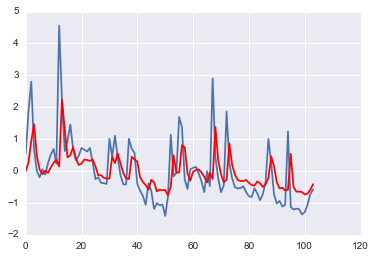

In [712]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(X_z[150], order=(2, 0, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(X_z[150])
plt.plot(results_ARIMA.fittedvalues, color='red')

## Remove outliers

In [631]:
#df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

outliers  = X_df_z.where(X_df_z.abs()>10).any(axis=1)


# df_outlier = X_df_z[outliers]

# mask = np.ones(len(X_z), dtype=bool)
# np_outliers = np.where(np.abs(X_z)>10)[0]
# mask[np_outliers]  = False
# print(mask)

# X_z = X_z[mask]

# print(X_z.shape)


# list_it = list(range(len(df_HistPerProduct_p2c1.columns)))[1:]
# tick_frequency = 4
# plt.figure(figsize=(10,10))
# for index, row in df_outlier.iterrows():
#     plt.plot(list(row),label = index)
# plt.xticks(list_it[::tick_frequency], list(df_HistPerProduct_p2c1.columns)[1::tick_frequency], rotation = 70)
# plt.legend(loc=0)
# plt.show()

# Principal Components Analysis
Apply a PCA on raw data (standardized), plot the the individual cloud then the correlation circle

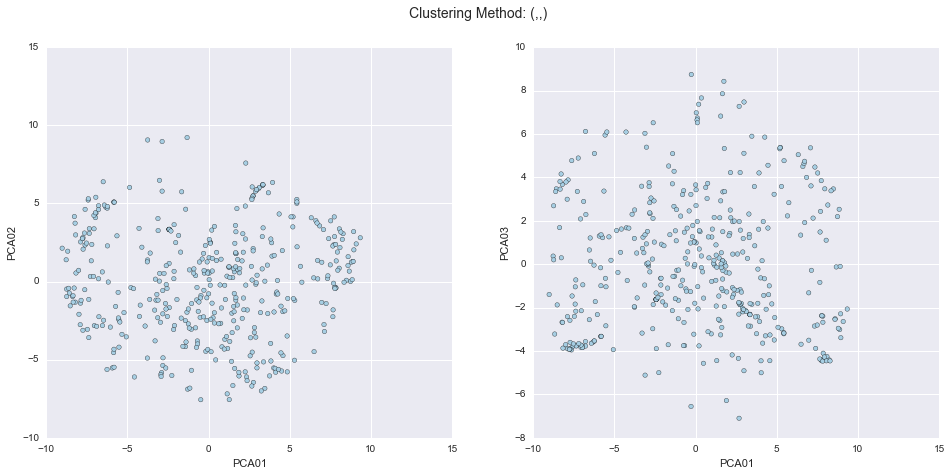

[ 0.22914644  0.11536091  0.09178983  0.05965695  0.0381238 ]


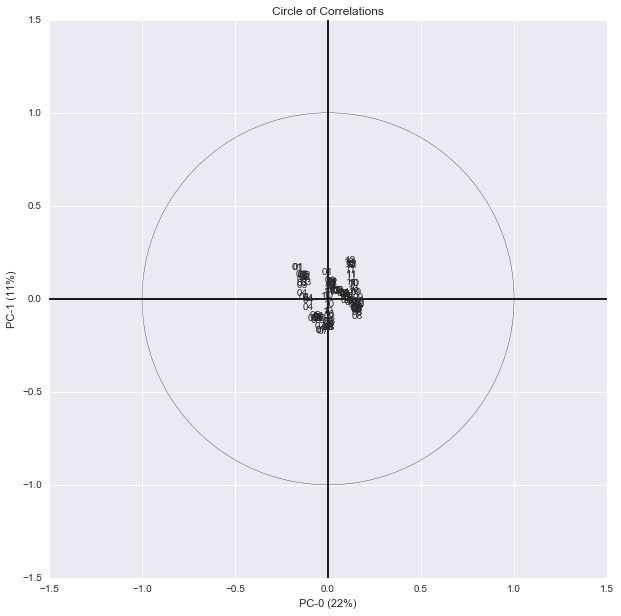

In [564]:
%matplotlib inline

X = X_z
nb_col=X.shape[1]
pca = PCA(n_components = nb_col)

pca.fit(X)  
princ_axis = pca.components_

X_pca= pca.transform(X)

hlp.Clusters_plot(X= X_pca, labels = np.zeros(len(X_pca)))
# for i, txt in enumerate(df_HistPerProduct_p2c1.ix[:,0]):
#     ax.annotate(i+1, (X_pca[i,0],X_pca[i,1]))
inertie = pca.explained_variance_ratio_
print(inertie[0:5])
comp = np.transpose(princ_axis)


hlp.circleOfCorrelations(comp,inertie,df_HistPerProduct_p2c1.columns[1:])
plt.show(block = True)

## PCA 01
It regroups products being sold more over time ie __increasing trend__ over the last two years

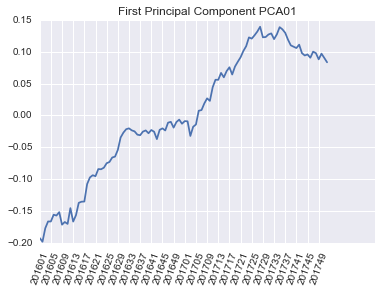

In [565]:
%matplotlib inline

tick_frequency = 4

plt.title("First Principal Component PCA01")
plt.plot(range(nb_col), princ_axis [0,:])
plt.xticks(range(nb_col)[::tick_frequency], list(df_HistPerProduct_p2c1.columns)[1::tick_frequency], rotation = 70)
plt.show()

## PCA 02
Opposes products in term of __sales seasonality__ being sold either in cold or hot seasons

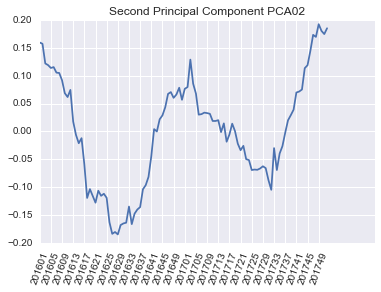

In [566]:
plt.title("Second Principal Component PCA02")
plt.plot(range(nb_col), princ_axis [1,:])
plt.xticks(range(nb_col)[::tick_frequency], list(df_HistPerProduct_p2c1.columns)[1::tick_frequency], rotation = 70)
plt.show()

## PCA 03
The curve seems strongly correlated to __one sales period__. Probably of one product 

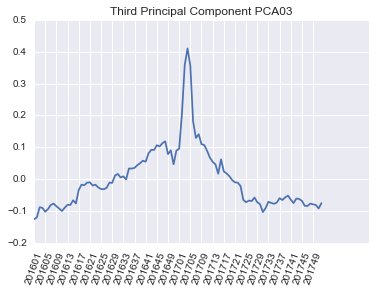

In [567]:
plt.title("Third Principal Component PCA03")
plt.plot(range(nb_col), princ_axis [2,:])
plt.xticks(range(nb_col)[::tick_frequency], list(df_HistPerProduct_p2c1.columns)[1::tick_frequency], rotation = 70)
plt.show()

### Plot the samples with the strongest correlation to components
On récupère les examples qui sont le plus corrélés avec un axe principal donné

In [568]:
component = 2
corrSamples = hlp.GetMostCorrelatedTo(X_pca,component)
corrSamples.head()


1    2    3    4    5    6    7    8    9    10  ...   95   96   97   \
286 1.33 9.22 4.28 0.52 0.02 1.53 1.29 0.97 1.15 0.01 ...  0.06 0.02 0.00   
213 3.76 9.06 2.50 0.02 1.27 0.77 1.99 1.02 1.14 0.83 ...  0.23 0.16 0.15   
114 2.87 8.96 3.58 0.13 2.09 0.79 0.65 1.10 1.38 0.79 ...  0.04 0.03 0.24   
126 2.29 7.58 1.96 0.92 0.98 0.77 2.22 3.52 1.14 2.51 ...  0.05 0.08 0.17   
175 0.49 7.56 0.57 1.20 2.03 0.24 0.75 2.14 0.55 0.57 ...  0.14 0.06 0.08   

     98   99   100  101  102  103  104  
286 0.10 0.05 0.01 0.06 0.17 0.14 0.00  
213 0.00 0.09 0.04 0.03 0.02 0.12 0.00  
114 0.05 0.22 0.17 0.02 0.01 0.08 0.00  
126 0.14 0.03 0.14 0.00 0.02 0.16 0.00  
175 0.10 0.18 0.25 0.06 0.05 0.03 0.00  

[5 rows x 104 columns]

### Compare the Most Correlated samples to its principal component
On vérifie si la séquence de l'exemple le plus corrélé suit le schéma de l'axe principal

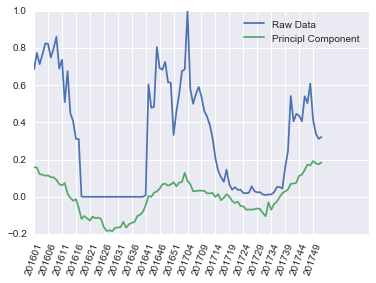

In [569]:
sample = corrSamples.index[1]-1

p_axe = princ_axis [component-1,:]
x = X_z[sample,:]
normalized = (x-min(x))/(max(x)-min(x))


tick_frequency = 5
plt.plot(normalized, label="Raw Data")
plt.plot(range(nb_col),p_axe , label="Principl Component")
plt.xticks(range(nb_col)[::tick_frequency], list(df_HistPerProduct_p2c1.columns)[1::tick_frequency], rotation = 70)
plt.legend()
plt.show()
    

# Clustering
Try out Hierarchical clustering, kMeans and kMedodis  on raw data. Then, plot the PCA to visualize the result of the clustering on the principal components

## Agglomerative Clustering

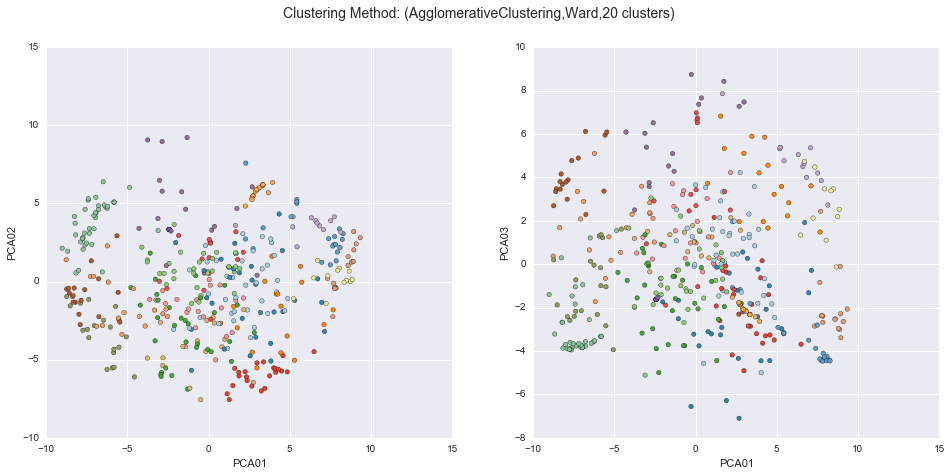

In [570]:
SSE = {}
n_cluster = 20

from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward').fit(X_z)
label = ward.labels_

SSE['Ward'] = hlp.getSSE(X_z,X_z[label])
hlp.Clusters_plot(X= X_pca, labels = label,info=["AgglomerativeClustering","Ward","%d clusters"%len(set(label))])

## Automated Cut-Off Selection

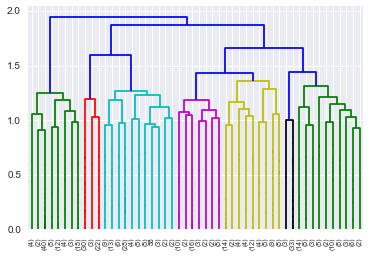

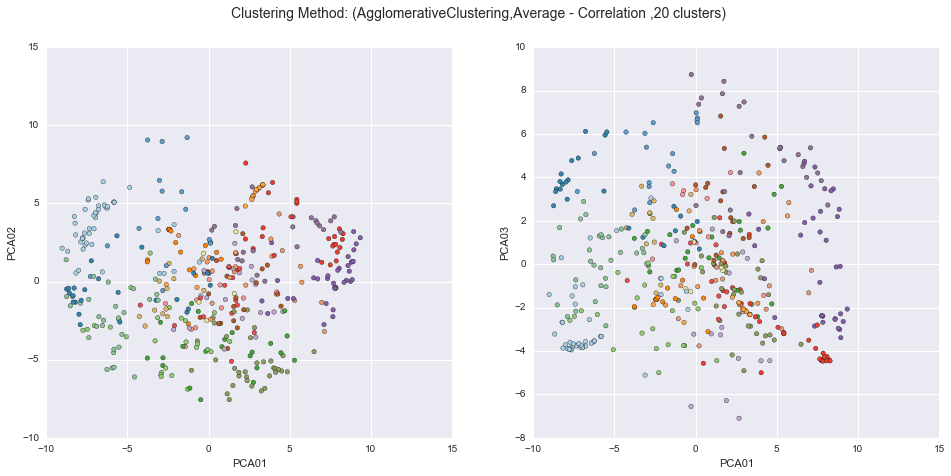

In [571]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt


Z = hierarchy.linkage(X_z, method='complete',metric='correlation')
dn = hierarchy.dendrogram(   Z, truncate_mode='lastp', p=50, leaf_rotation=90., leaf_font_size=7., show_contracted=True)
plt.show()



plt.figure()
labels = hierarchy.fcluster(Z, t=n_cluster ,criterion = 'maxclust')
hlp.Clusters_plot(X= X_pca, labels = labels,info=["AgglomerativeClustering","Average - Correlation ","%d clusters"%len(set(labels))])

labels_h_cc = labels

SSE["Agg_complete"] = hlp.getSSE(X_z,X_z[labels_h_cc])

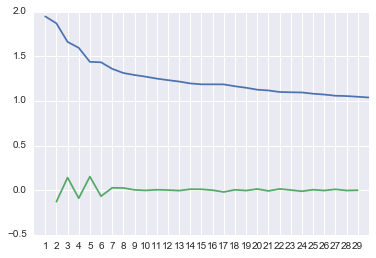

clusters: [ 5  3  2  4  6  7  8 17 22 20 24 14 15 27 21 13 25 11 19 26 18 28  9 10 23
 12 29 16]


In [572]:
last = Z[-30:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.xticks(np.arange(1,len(last)))
plt.show()
best_ks = np.abs(acceleration_rev).argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

## K-means

In [573]:
%matplotlib inline

kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_z)
label = kmeans.labels_
labels_kmeans = label

SSE["kMeans"] = hlp.getSSE(X_z,X_z[labels_kmeans])

### PCA representation of the clustering

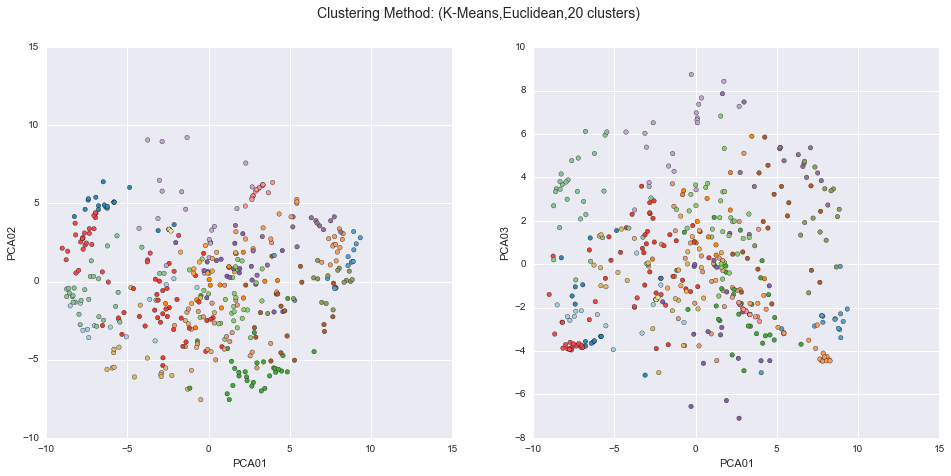

In [574]:
X = X_pca[:,:3]
hlp.Clusters_plot(X= X_pca, labels = label,info=["K-Means","Euclidean","%d clusters"%len(set(label))])

### TSNE representation of the clustering

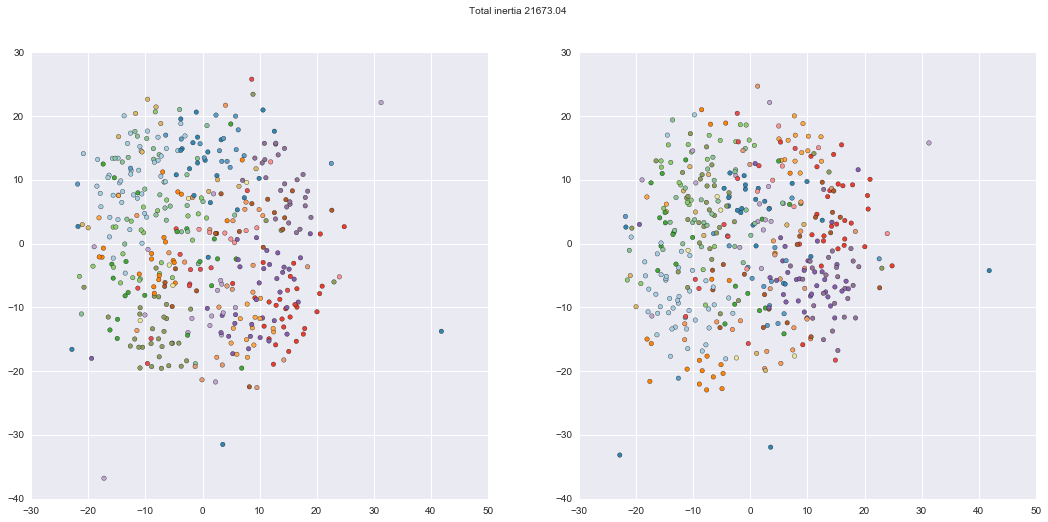

In [575]:
%matplotlib inline


X_tsne = TSNE(n_components = 3).fit_transform(X_z)

plt.figure(figsize=(18,8))
colors = [str(item/255.) for item in labels]
plt.suptitle("Total inertia %.02f"%kmeans.inertia_)  
plt.subplot(1,2,1)
plt.scatter(X_tsne[:,0],X_tsne[:,1],cmap ="Paired" ,c=colors)
plt.subplot(1,2,2)
plt.scatter(X_tsne[:,0],X_tsne[:,2],cmap ="Paired" ,c=colors)
plt.show(block = True)

### K-Means: Validate different numbers of clusters

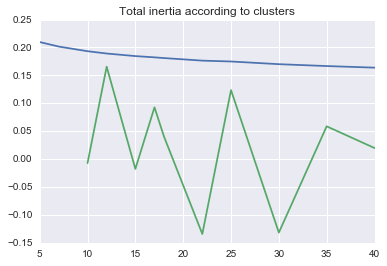

In [576]:
%matplotlib inline
clusters= np.array([5,7,10,12,15,17,18,22,25,30,35,40])

inertia = []
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, random_state=0).fit(X_z)
    inertia += [np.sqrt(kmeans.inertia_/len(kmeans.labels_))]
    
inertia = np.array(inertia) #scale it to acc2
plt.title("Total inertia according to clusters")    
plt.plot(clusters,inertia/40)
acc = np.diff(inertia, 2)  # 2nd derivative of the inertia curve
big_acc = acc.argsort()
plt.plot(clusters[2:],acc)

plt.show()

# Custom Distances

In [577]:
%load_ext autoreload
%autoreload 1
%aimport Helpers

import kMedoids
from scipy.spatial.distance import pdist,squareform

n_obs = X_z.shape[1]
corr_distance = squareform(pdist(X_z, 'correlation'))
euclid_distance = squareform(pdist(X_z, 'euclidean'))
sqcorr_distance = corr_distance**2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## K-medoids (Correlation distance)

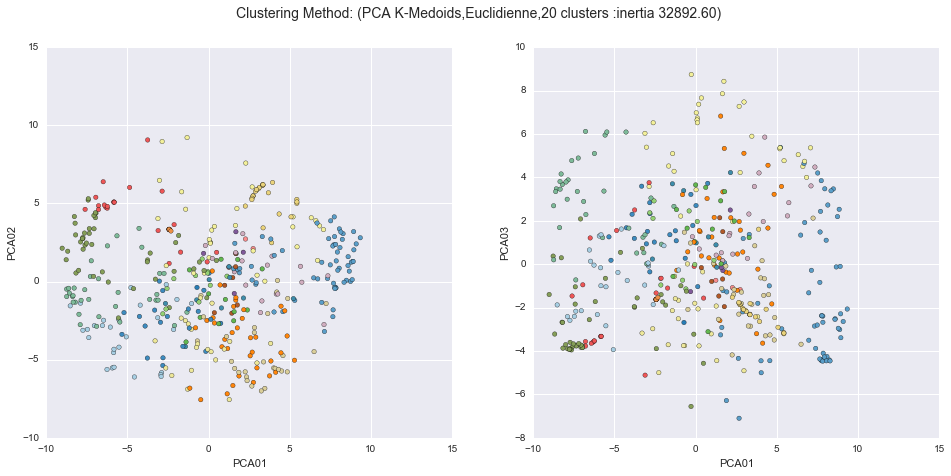

In [579]:
label, medoids = kMedoids.cluster(euclid_distance,k= n_cluster)
labels_kmedoids = label

labels_kmedoids_corr,medoids = kMedoids.cluster(corr_distance,k= n_cluster)


SSE["kMedoids"] = hlp.getSSE(X_z,X_z[labels_kmedoids])
SSE["kMedoids_corr"] = hlp.getSSE(X_z,X_z[labels_kmedoids_corr])

hlp.Clusters_plot(X= X_pca, labels = label
                  ,info=["PCA K-Medoids","Euclidienne","%d clusters :inertia %.2f"%(len(set(label)),SSE["kMedoids"])])
#hlp.Clusters_plot(X= X_tsne, labels = label,info=["TSNE K-Medoids","Correlation","%d clusters"%len(set(label))])

## BIRCH Algorithm

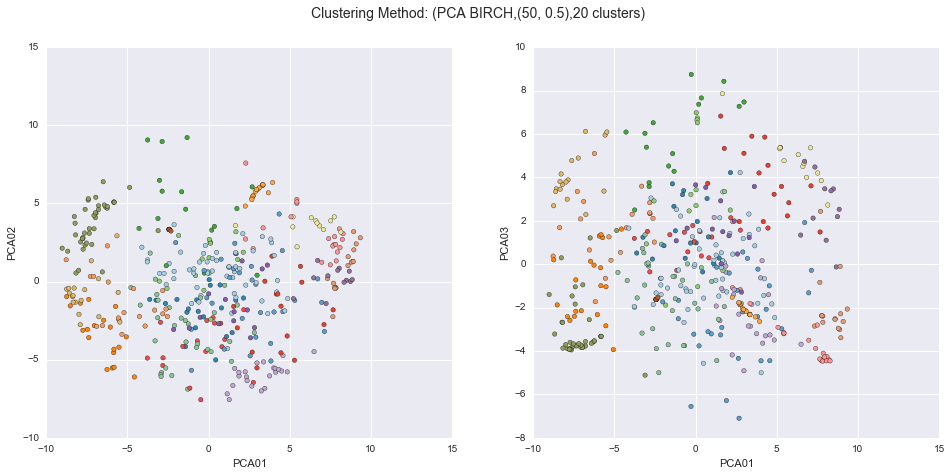

In [580]:
label = Birch(n_clusters= n_cluster, threshold=0.5, compute_labels=True).fit_predict(X_z)
labels_birch = label

SSE["Birch"] = hlp.getSSE(X_z,X_z[labels_birch])

hlp.Clusters_plot(X= X_pca, labels = label,info=["PCA BIRCH","(50, 0.5)","%d clusters"%len(set(label))])

In [581]:
for k,v in SSE.items():
    print(" \"%s\" : %.2f"%(k,v))

 "Ward" : 87443.86
 "Agg_complete" : 87398.95
 "kMedoids" : 32892.60
 "kMedoids_corr" : 35453.59
 "kMeans" : 80475.88
 "Birch" : 90632.66


## SOM

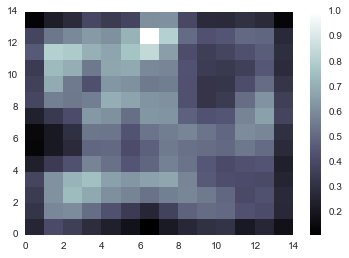

In [251]:
from minisom import MiniSom   


som = MiniSom(14, 14, 104, sigma=0.5, learning_rate=0.1) # initialization of 6x6 SOM

som.train_batch(X_z, 1000) # trains the SOM with 100 iterations

# Plotting the response for each pattern in the iris dataset
plt.bone()
plt.pcolor(som.distance_map().T)  # plotting the distance map as background
plt.colorbar()

qnt = som.quantization(X_z)
x,y = som.winner(X_z[0])


plt.show()




# Save Clustering Results

In [624]:
processed_path = "..\\data\\processed\\"
file_name = "p2c1_clustering_20medoids_V2.csv"

def labels_to_df(labels):
    clusters = dict()

    for i,l in enumerate(list(set(labels))):
        clusters[l] = i+1

    groups = list(product_df['product'][~outliers])
    rows=[]
    for i,g in enumerate(groups):
        c = labels[i]
        rows.append([g,clusters[c],groups[c]])


    label_df = pd.DataFrame(rows,index = np.array(rows)[:,0],columns = ["Product Group key","Cluster","Centroid"])
    return label_df





eucl_df = labels_to_df(labels_kmedoids)
corr_df = labels_to_df(labels_kmedoids_corr)

#eucl_df.to_csv(processed_path+file_name, sep=';', encoding='utf-8')

# Display Clustering Results

In [629]:
def Cluster_series_plot(data_df,cluster_df):
    
    list_it = list(range(len(data_df.columns)))
    tick_frequency = 3
    
    clusters = list(set(cluster_df['Cluster']))
    nc = len(clusters)
    
    clusters_array = []
    
    plt.figure(figsize=(15,60))
    for i,c in enumerate(clusters):
        plt.subplot(nc,1,i+1)
        cluster = list(cluster_df[cluster_df['Cluster']==c].iloc[:,0])
        plt.title("Cluster %d: %d product"%(i+1,len(cluster)))
        df  = X_df[data_df['product'].isin(cluster)]
        for index, row in df.iterrows():
            plt.plot(list(row),label = index)
        plt.xticks(list_it[1::tick_frequency], list(data_df.columns)[1::tick_frequency], rotation = 70)
        clusters_array += [[i,cluster]]
        #plt.legend(loc=0)
    plt.tight_layout()
    #plt.show()
    return clusters_array

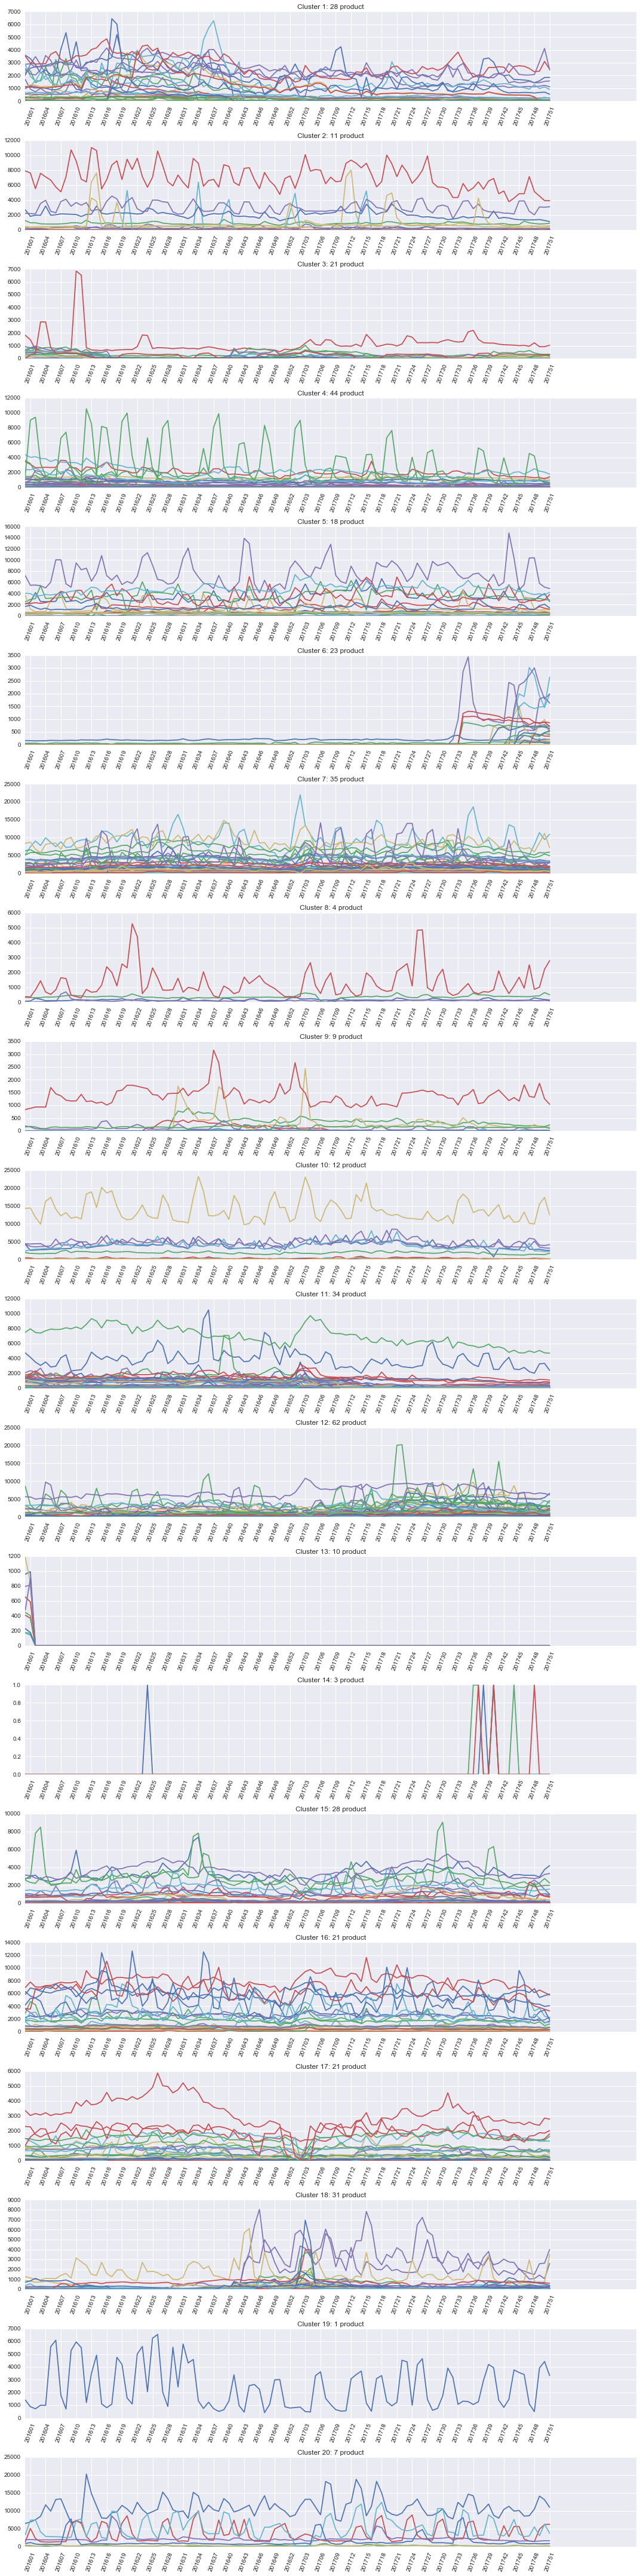

In [630]:
carr =Cluster_series_plot(data_df = product_df, cluster_df = eucl_df)

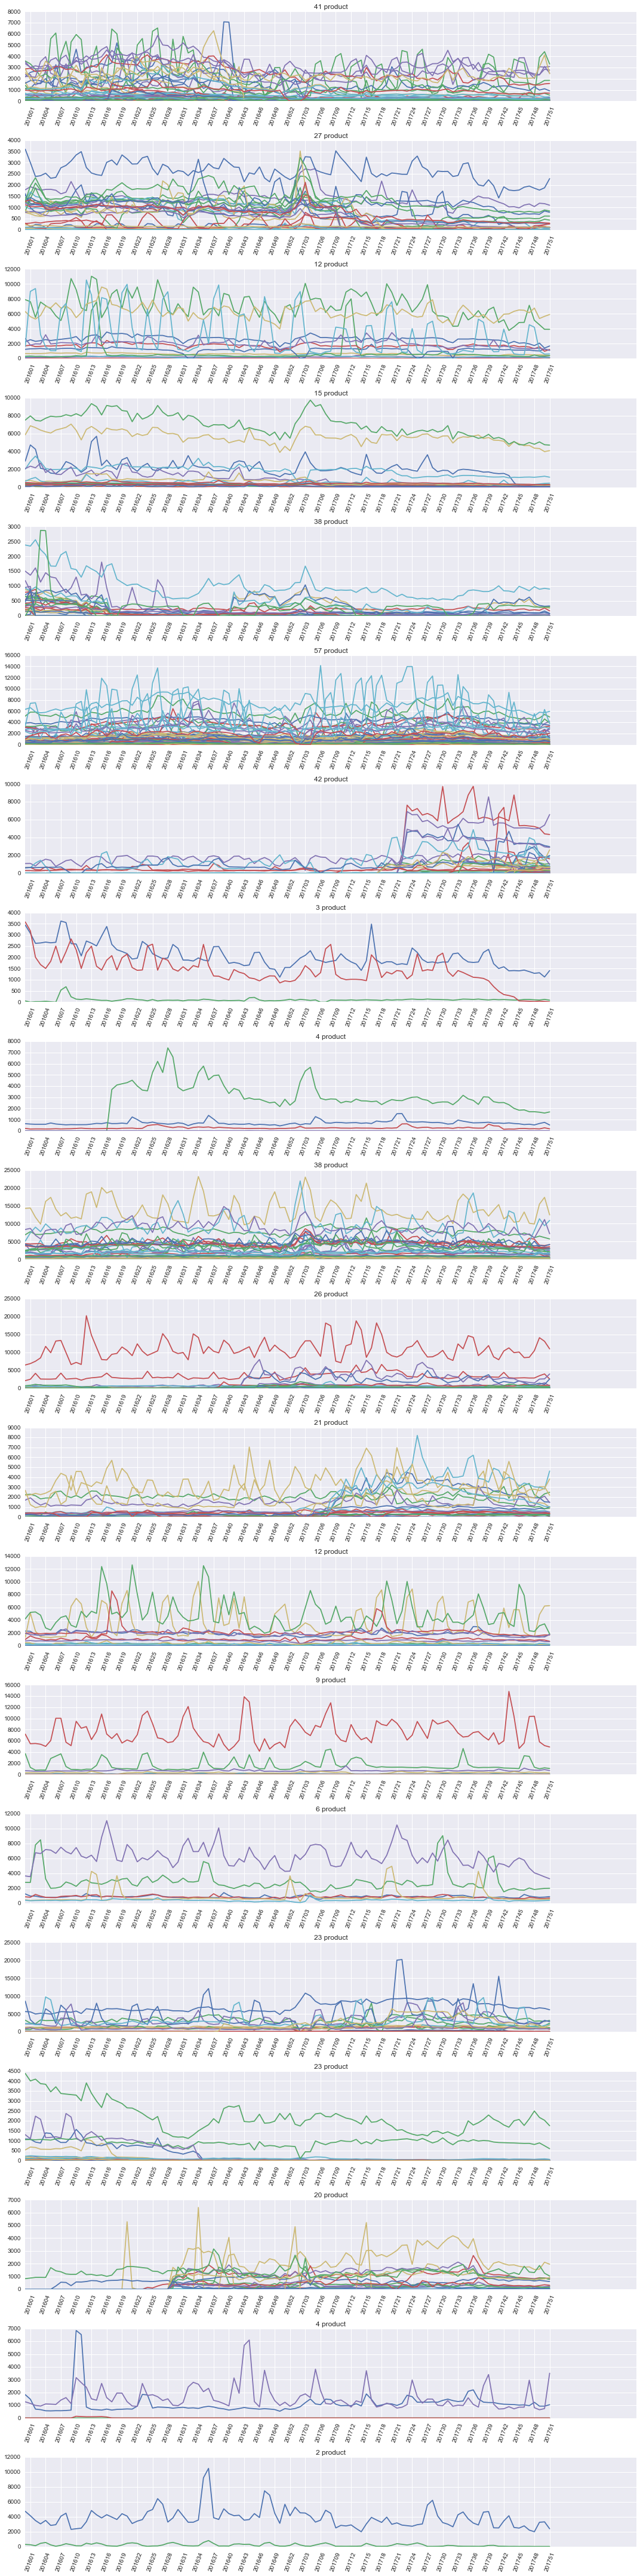

In [599]:
Cluster_series_plot(data_df = product_df, cluster_df = corr_df)

In [617]:
print(carr[0])

[0, ['GLA001VLR125FS', 'GWX001BND100FS', 'GWA010PAM150FS', 'GLV005CQT100FS', 'GCO002SGM100FS', 'TRZ014BND200FR', 'GWC012BNR1K0FS', 'GQX131VLR166BQ', 'GCH006CAR250FP', 'GWS062BND100SS', 'GWA002BND100FS', 'GWG027BND170FP', 'GLA001ESE200FS', 'GCO002SPV100FP', 'TCW004BND200FR', 'GWM007NTA150FS', 'GBF006BND125FR', 'GCO002NEU080FS', 'GWP007PAM200FS', 'GBF004BND146FR', 'GBF039BND125FR', 'GBA001BND060SS', 'GWF002BND250FS', 'GWS063BND125SS', 'TPT001BND300BW', 'GWJ012FTG100FS', 'GLV001CQT125FS', 'GWC013CQT250FS']]
